# Group 15 Project 2

**Team Members:**
- Akshay Navaneetha Krishnan (an34244)
- Ayaan Khan (ak46396)
- Cheng-Ya (Monica) Liou (cl49358)
- Vaibhav Nagar (vn5339)


In [1]:
#Importing Packages
import pandas as pd
import gurobipy as gp
import matplotlib.pyplot as plt

# Change time limit for optimizing with method 2

In [2]:
#Time limit for MIP problem 4
time_limit=3600

# Processing the data

In [3]:
#Calculating the returns, correlations for 2019 and 2020 data
#Initializing variables such as total number of stocks, list of stock names
data_2019 = pd.read_csv("stocks2019.csv", parse_dates=[0], infer_datetime_format=True)
data_2019.sort_values(by=data_2019.columns[0],inplace=True)
stocks_list=data_2019.iloc[:,2:].columns
number_stocks=len(stocks_list)

combined_filtered=data_2019.iloc[:,2:].pct_change().dropna().reset_index(drop=True)
combined_filtered.columns = [col + '_returns' for col in combined_filtered.columns]
index_returns=data_2019.iloc[:,1].pct_change().dropna().reset_index(drop=True)

corr_matrix = combined_filtered.corr()
corr_list = corr_matrix.values.tolist()

data_2020=pd.read_csv("stocks2020.csv",parse_dates=[0], infer_datetime_format=True)
data_2020.sort_values(by=data_2020.columns[0],inplace=True)
stocks_list_2020=data_2020.iloc[:,2:].columns
number_stocks_2020=len(stocks_list_2020)

combined_filtered_2020=data_2020.iloc[:,2:].pct_change().dropna()
combined_filtered_2020.columns = [col + '_returns' for col in combined_filtered_2020.columns]
index_returns_2020=data_2020.iloc[:,1].pct_change().dropna()

# Optimizing using method 1

In [4]:
iter_range=[5]+list(range(10,number_stocks+1,10))

In [5]:
#Initializing lists to append gurobi model results
in_sample=[]
out_sample=[]
plot_2019=[]
plot_2020=[]
from tqdm import tqdm

with pd.ExcelWriter("Method1Selection.xlsx", engine='xlsxwriter') as writer:
    for i in tqdm(iter_range, desc="Trying various number of stocks for index"):

        m=i
        # Initializing Stock Selection Model
        sf19=gp.Model()
        # Decision variable that represents the best representative stock out of the selected stocks
        best_rep = sf19.addMVar((number_stocks,number_stocks),vtype="B")
        # Decision variable that represents whether the stock was selected for the fund
        selected_stock= sf19.addMVar((number_stocks),vtype="B")
        # Objective function to maximizing the correlation 
        sf19.setObjective(gp.quicksum(corr_list[i][j]*best_rep[i][j] for i in range(number_stocks) for j in \
                          range(number_stocks)),sense=gp.GRB.MAXIMIZE)
        # Constraint to only select m stocks
        sf19.addConstr(gp.quicksum(selected_stock[i] for i in range(number_stocks))==m)
        # Constraint to make sure every stock has a representative stock
        sf19.addConstrs(gp.quicksum(best_rep[i][j] for j in range(number_stocks))==1 for i in range(number_stocks))
        # Constraint to make sure the representative stock is also a selected stock
        sf19.addConstrs(best_rep[i][j]<=selected_stock[j] for i in range(number_stocks) for j in \
                          range(number_stocks))
        sf19.setParam('OutputFlag', 0)
        sf19.optimize()
        # List containing the selected stocks after optimizing the model
        selected_list=[int(x) for x in selected_stock.x]

        # Returns of the stocks that were selected above for 2019
        selected_columns = combined_filtered.loc[:, [i==1 for i in selected_list]]
        
        # Initializing the model to select the weights for the above selected stocks
        weights=gp.Model()
        # Decision variable that represents the weight of each stock
        w = weights.addMVar((sum(selected_list)),vtype="C")
        # Proxy variable to represent absolute values in the objective function
        bounds = weights.addMVar(len(selected_columns),vtype="C")
        #Objective function to minimize the daily absolute return difference between fund and index
        weights.setObjective(gp.quicksum(bounds[i] for i in range(len(selected_columns))))
        # Constraint to make the sum of weights to be 1
        weights.addConstr(gp.quicksum(w[i]  for i in range(sum(selected_list)))==1)
        # Adding the lower and upper bounds to imitate an absolute difference
        weights.addConstrs(bounds[j]>=(index_returns[j]-gp.quicksum(selected_columns.iloc[j,i]*w[i] for i\
                                      in range(sum(selected_list)))) for j in range(len(selected_columns)))
        weights.addConstrs(bounds[j]>=-1*(index_returns[j]-gp.quicksum(selected_columns.iloc[j,i]*w[i] for i\
                                      in range(sum(selected_list)))) for j in range(len(selected_columns)))
        weights.setParam('OutputFlag', 0)
        weights.optimize()
        # Returns of the stocks that were selected above for 2020
        selected_columns_2020=combined_filtered_2020[[x+"_returns" for x in stocks_list[[i==1 for i in selected_list]]]]
        
        # Calculating the returns for the created fund, and the error metrics
        df_result_2020 = selected_columns_2020.mul(w.x, axis=1)
        df_result_2019 = selected_columns.mul(w.x, axis=1)
        df_result_2020=df_result_2020.sum(axis=1)
        df_result_2019=df_result_2019.sum(axis=1)
        metric_2020=(df_result_2020 - index_returns_2020).abs().sum()
        metric_2019=(df_result_2019 - index_returns).abs().sum()
        
        #Saving the stock selection and weights for each configuration
        df=pd.DataFrame({"Stock_Name":stocks_list[[i==1 for i in selected_list]],"Weights":w.x})
        df.to_excel(writer, sheet_name=f'{m}', index=False)
        
        #Appending the error metric results and the new funds created
        in_sample.append(metric_2019)
        out_sample.append(metric_2020)
        plot_2019.append(df_result_2019)
        plot_2020.append(df_result_2020)


Trying various number of stocks for index:   0%|                                                | 0/11 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-20


Trying various number of stocks for index: 100%|███████████████████████████████████████| 11/11 [07:09<00:00, 39.01s/it]


In [6]:
#Saving results to csv to avoid re running

accuracy_df_first=pd.DataFrame({'in_sample': in_sample,'out_sample':out_sample})
accuracy_df_first.to_csv("accuracy_df_first.csv",index=False)
plot_2019_first_df=pd.DataFrame()
for i,value in enumerate(plot_2019):
    plot_2019_first_df[f"{i}"]=value
plot_2019_first_df.to_csv("plot_2019_first_df.csv",index=False)
plot_2020_first_df=pd.DataFrame()
for i,value in enumerate(plot_2020):
    plot_2020_first_df[f"{i}"]=value
plot_2020_first_df.to_csv("plot_2020_first_df.csv",index=False)

In [7]:
#Reading saved results
accuracy_df_first=pd.read_csv("accuracy_df_first.csv")
plot_2019_first_df=pd.read_csv("plot_2019_first_df.csv")
plot_2020_first_df=pd.read_csv("plot_2020_first_df.csv")

in_sample=list(accuracy_df_first["in_sample"])
out_sample=list(accuracy_df_first["out_sample"])

plot_2019=[]
for column_name, column_data in plot_2019_first_df.items():
    plot_2019.append(column_data)
plot_2020=[]
for column_name, column_data in plot_2020_first_df.items():
    plot_2020.append(column_data)

# Visualizing method 1 results

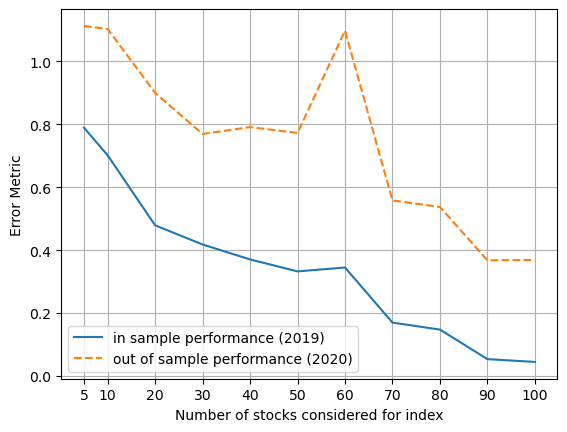

In [8]:
# Error Visualized
x_axis = iter_range

# Create a line plot
plt.plot(x_axis, in_sample, label='in sample performance (2019)')
plt.plot(x_axis, out_sample,  linestyle='--', label='out of sample performance (2020)')

# Set axis labels and legend
plt.xlabel('Number of stocks considered for index')
plt.ylabel('Error Metric')
plt.legend()

plt.xticks(iter_range)

# Show the plot
plt.grid(True)
plt.show()

Pick number of stocks from the below range

In [9]:
iter_range

[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [10]:
number_of_stocks=5
index=iter_range.index(number_of_stocks)

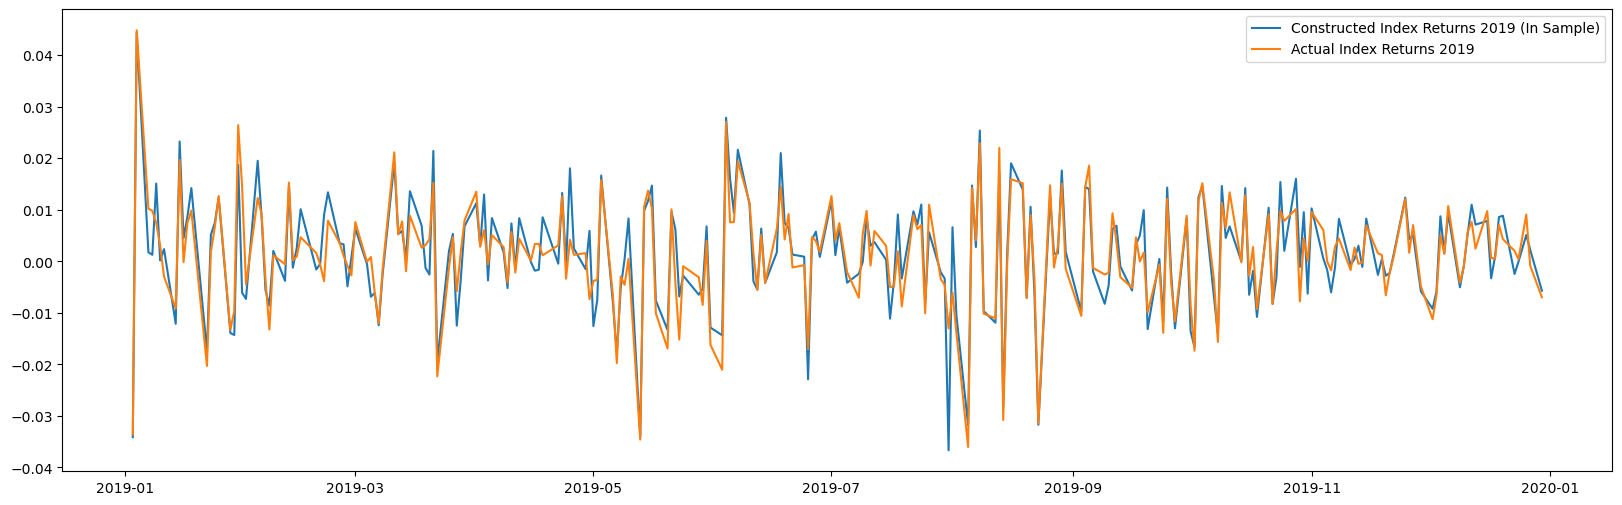

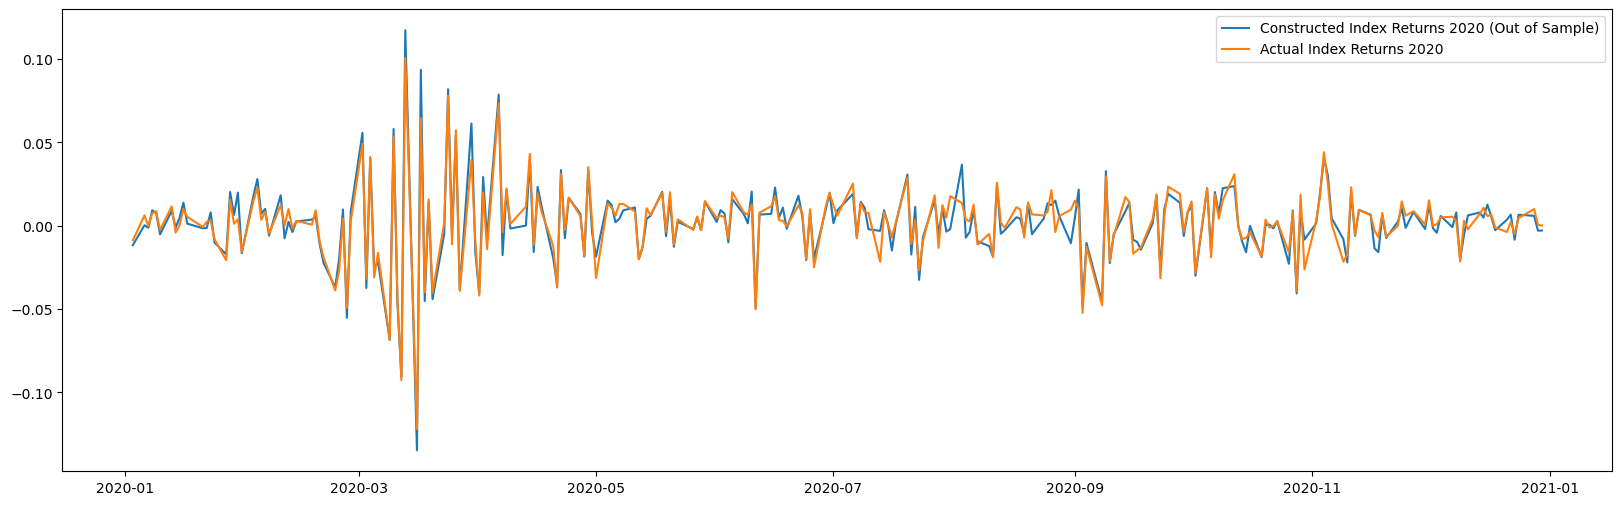

In [11]:
#Visualizing the created fund next to the index

x_axis = data_2019.iloc[1:,0].reset_index(drop=True)
plt.figure(figsize=(20,6))
# Create a line plot
plt.plot(x_axis, plot_2019[index], label='Constructed Index Returns 2019 (In Sample)')
plt.plot(x_axis, index_returns, label='Actual Index Returns 2019')

plt.legend()

plt.show()

x_axis = data_2020.iloc[1:,0].reset_index(drop=True)
plt.figure(figsize=(20,6))
# Create a line plot
plt.plot(x_axis, plot_2020[index], label='Constructed Index Returns 2020 (Out of Sample)')
plt.plot(x_axis, index_returns_2020, label='Actual Index Returns 2020')

plt.legend()

plt.show()

# Optimizing using method 2

In [12]:
#Initializing lists to append gurobi model results
in_sample_m2=[]
out_sample_m2=[]
plot_2019_m2=[]
plot_2020_m2=[]
from tqdm import tqdm
with pd.ExcelWriter("Method2Selection.xlsx", engine='xlsxwriter') as writer:
    for i in tqdm(iter_range, desc="Trying various number of stocks for index"):

        m=i
        #List with all stocks (we don't select the stocks initially)
        selected_list=[1 for x in range(len(combined_filtered.columns))]

        selected_columns = combined_filtered.loc[:, [i==1 for i in selected_list]]
        
        #Initializing the model to both select the weights and pick the stocks
        weights=gp.Model()
        # Decision variable that represents the weight of each stock
        w = weights.addMVar((sum(selected_list)),vtype="C")
        # Proxy variable to represent absolute values in the objective function
        bounds = weights.addMVar(len(selected_columns),vtype="C")
        # Variable that represents whether the stock was used in the fund or not
        utilized=weights.addMVar((sum(selected_list)),vtype="B")
        
        #Objective function to minimize the daily absolute return difference between fund and index
        weights.setObjective(gp.quicksum(bounds[i] for i in range(len(selected_columns))))
        # Big M constraint with M=1, to ensure that if a stock has non zero weight, it is utilized
        weights.addConstrs(utilized[i]>=w[i] for i in range(sum(selected_list)))
        # Constraint to make the sum of weights to be 1
        weights.addConstr(gp.quicksum(w[i]  for i in range(sum(selected_list)))==1)
        # Constraint to ensure than m stocks are selected
        weights.addConstr(gp.quicksum(utilized[i]  for i in range(sum(selected_list)))==m)
        # Adding the lower and upper bounds to imitate an absolute difference
        weights.addConstrs(bounds[j]>=(index_returns[j]-gp.quicksum(selected_columns.iloc[j,i]*w[i] for i\
                                      in range(sum(selected_list)))) for j in range(len(selected_columns)))
        weights.addConstrs(bounds[j]>=-1*(index_returns[j]-gp.quicksum(selected_columns.iloc[j,i]*w[i] for i\
                                      in range(sum(selected_list)))) for j in range(len(selected_columns)))
        weights.setParam('OutputFlag', 0)
        weights.setParam('TimeLimit', time_limit)
        weights.optimize()
        weights.objVal
        
        # Returns of the stocks that were selected above for 2020
        selected_columns_2020=combined_filtered_2020[[x+"_returns" for x in stocks_list[[i==1 for i in selected_list]]]]
        
        # Calculating the returns for the created fund, and the error metrics
        df_result_2020 = selected_columns_2020.mul(w.x, axis=1)
        df_result_2019 = selected_columns.mul(w.x, axis=1)
        df_result_2020=df_result_2020.sum(axis=1)
        df_result_2019=df_result_2019.sum(axis=1)
        metric_2020=(df_result_2020 - index_returns_2020).abs().sum()
        metric_2019=(df_result_2019 - index_returns).abs().sum()
        
        #Saving the stock selection and weights for each configuration
        df=pd.DataFrame({"Stock_Name":stocks_list[[i==1 for i in selected_list]],"Weights":w.x,"Used":utilized.x})
        df=df[df["Used"]==1]
        df.to_excel(writer, sheet_name=f'{m}', index=False)
        
        #Appending the error metric results and the new funds created
        in_sample_m2.append(metric_2019)
        out_sample_m2.append(metric_2020)
        plot_2019_m2.append(df_result_2019)
        plot_2020_m2.append(df_result_2020)

Trying various number of stocks for index: 100%|███████████████████████████████████| 11/11 [7:54:27<00:00, 2587.93s/it]


In [13]:
#Saving results to csv to avoid re running
accuracy_df_second=pd.DataFrame({'in_sample_m2': in_sample_m2,'out_sample_m2':out_sample_m2})
accuracy_df_second.to_csv("accuracy_df_second.csv",index=False)
plot_2019_second_df=pd.DataFrame()
for i,value in enumerate(plot_2019_m2):
    plot_2019_second_df[f"{i}"]=value
plot_2019_second_df.to_csv("plot_2019_second_df.csv",index=False)
plot_2020_second_df=pd.DataFrame()
for i,value in enumerate(plot_2020_m2):
    plot_2020_second_df[f"{i}"]=value
plot_2020_second_df.to_csv("plot_2020_second_df.csv",index=False)

In [14]:
#Reading saved results
accuracy_df_first=pd.read_csv("accuracy_df_second.csv")
plot_2019_second_df=pd.read_csv("plot_2019_second_df.csv")
plot_2020_second_df=pd.read_csv("plot_2020_second_df.csv")

in_sample_m2=list(accuracy_df_first["in_sample_m2"])
out_sample_m2=list(accuracy_df_first["out_sample_m2"])

plot_2019_m2=[]
for column_name, column_data in plot_2019_second_df.items():
    plot_2019_m2.append(column_data)
plot_2020_m2=[]
for column_name, column_data in plot_2020_second_df.items():
    plot_2020_m2.append(column_data)

# Visualizing results from both approaches

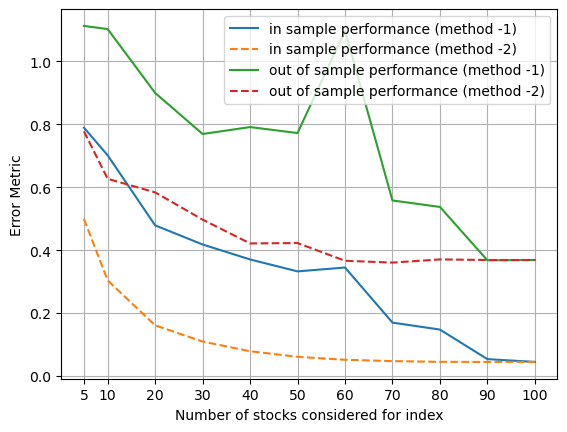

In [15]:
# Visualizing in and out of sample errors for both the approaches
x_axis = iter_range

# Create a line plot
plt.plot(x_axis, in_sample, label='in sample performance (method -1)')
plt.plot(x_axis, in_sample_m2,  linestyle='--',label='in sample performance (method -2)')
plt.plot(x_axis, out_sample, label='out of sample performance (method -1)')
plt.plot(x_axis, out_sample_m2, linestyle='--', label='out of sample performance (method -2)')

# Set axis labels and legend
plt.xlabel('Number of stocks considered for index')
plt.ylabel('Error Metric')
plt.legend(loc='best')

plt.xticks(x_axis)
plt.grid(True)
# Show the plot
plt.show()